In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn.metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd

## Loading the Data in Python

In [2]:
df = pd.read_csv('df_clean2.csv')
df

,Sev,StartLat,StartLng,Dist(mi),DfTyp(mins),DfFF(mins),CongSp,City,County,State,...,Vis(mi),WindDir,StartTime,EndTime,Precip(in),Year,Month,Day,TOD,Season
0,0,40.119274,-83.03465,1.80,0,1,Fast,Columbus,Franklin,OH,...,7.0,NW,12:42:00,13:16:05,0.00,2016,2,8,Afternoon,Winter
1,0,40.119274,-83.03465,1.80,0,1,Fast,Columbus,Franklin,OH,...,7.0,NW,12:42:00,13:16:05,0.02,2016,2,8,Afternoon,Winter
2,0,40.119274,-83.03465,1.80,0,1,Fast,Columbus,Franklin,OH,...,7.0,NW,12:42:00,13:16:05,0.02,2016,2,8,Afternoon,Winter
3,0,40.119274,-83.03465,1.80,0,1,Fast,Columbus,Franklin,OH,...,7.0,NW,12:42:00,13:16:05,0.03,2016,2,8,Afternoon,Winter
4,0,40.119274,-83.03465,1.80,0,1,Fast,Columbus,Franklin,OH,...,7.0,NW,12:42:00,13:16:05,0.00,2016,2,8,Afternoon,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4617851,2,41.026596,-81.50227,3.47,4,4,Moderate,Akron,Summit,OH,...,10.0,VAR,19:02:00,20:01:44,0.00,2022,9,8,Night,Fall
4617852,2,41.026596,-81.50227,3.47,4,4,Moderate,Akron,Summit,OH,...,10.0,VAR,19:02:00,20:01:44,0.00,2022,9,8,Night,Fall
4617853,0,30.512320,-90.39422,1.42,1,1,Fast,Hammond,Tangipahoa,LA,...,7.0,N,19:57:00,20:57:20,0.00,2022,9,8,Night,Fall
4617854,0,30.512320,-90.39422,1.42,1,1,Fast,Hammond,Tangipahoa,LA,...,7.0,N,19:57:00,20:57:20,0.00,2022,9,8,Night,Fall


# SARIMAX ANALYSIS

## Formating Date column for time series analysis

In [3]:
# creating the date column
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df.set_index('Date', inplace=True)
df = df[df.index.year != 2016]


In [4]:
weekly_avg_df = df.resample('W').agg({'DfFF(mins)': 'mean',
                                      'Temp(F)': 'mean',
                                      'Hum(%)': 'mean',
                                      'Pres(in)': 'mean',
                                      'Vis(mi)': 'mean'})

# split into endogenous and exogenous variables
endog = weekly_avg_df['DfFF(mins)']
exog = weekly_avg_df[['Temp(F)', 'Hum(%)', 'Pres(in)', 'Vis(mi)']]


## Create line plot to view trend

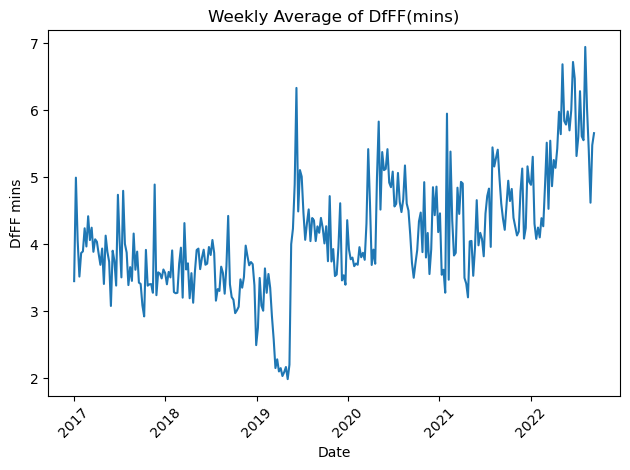

In [5]:

#resetting the index to make 'Date' a column
weekly_avg_df_reset = endog.reset_index()


weekly_avg_df_reset.columns = ['date', 'DfFF(mins)']  # Here 'meantemp' stands in for your 'DfFF(mins)'

#plotting the data
sns.lineplot(x='date', y='DfFF(mins)', data=weekly_avg_df_reset)

plt.title('Weekly Average of DfFF(mins)')
plt.xlabel('Date')
plt.ylabel('DfFF mins')  
plt.xticks(rotation=45) 
plt.tight_layout()  
plt.show()

## Creating a Time Series Decomposition Plot To Check For Seasonality In The Data

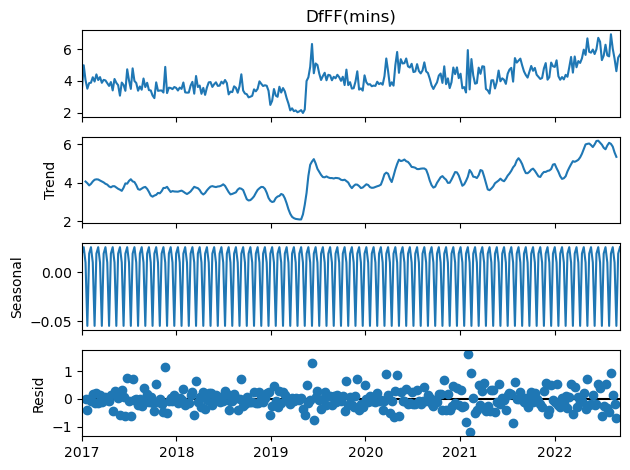

In [6]:
# decomposing the time series
result = seasonal_decompose(weekly_avg_df['DfFF(mins)'], model='additive', period=4)  
# plotting the decomposed components
result.plot()
plt.show()

- **Observed (DfFF(mins))**: Fluctuating time series data from 2017 to 2022, without a clear long-term trend.
- **Trend**: Smooth fluctuations suggest longer-term cycles without a consistent directional trend.
- **Seasonal**: Strong, consistent seasonal pattern repeated monthly(4 weeks).
- **Residual (Resid)**: Scatter of residuals around zero, indicating random noise after accounting for trend and seasonality.

## Implementing the Augmented Dickey-Fuller (ADF) test to determine stationarity

In [7]:
result = adfuller(weekly_avg_df['DfFF(mins)'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.303659
p-value: 0.014716
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572


The ADF statistic is closer to the critical values, and the p-value is below 0.05, which suggests that there is enough statistical evidence to reject the null hypothesis of non-stationarity at the 5% level. Therefore, we can infer that the time series is likely stationary, meaning

## Optimal SARIMA Model Selection with Auto ARIMA



In [8]:
import pmdarima as pm


smodel = pm.auto_arima(weekly_avg_df['DfFF(mins)'],
                       seasonal=True, 
                       m=4,
                       d=1, D=1, 
                       start_p=0, start_q=0, start_P=0, start_Q=0,
                       max_p=3, max_q=3, max_P=3, max_Q=3,
                       stepwise=True,
                       trace=True,
                       error_action='ignore',  
                       suppress_warnings=True)

print(smodel.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=752.144, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=608.511, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=inf, Time=0.48 sec
 ARIMA(1,1,0)(0,1,0)[4]             : AIC=707.395, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[4]             : AIC=581.078, Time=1.32 sec
 ARIMA(1,1,0)(3,1,0)[4]             : AIC=564.800, Time=2.12 sec
 ARIMA(1,1,0)(3,1,1)[4]             : AIC=inf, Time=7.92 sec
 ARIMA(1,1,0)(2,1,1)[4]             : AIC=inf, Time=7.04 sec
 ARIMA(0,1,0)(3,1,0)[4]             : AIC=628.836, Time=1.17 sec
 ARIMA(2,1,0)(3,1,0)[4]             : AIC=558.115, Time=2.30 sec
 ARIMA(2,1,0)(2,1,0)[4]             : AIC=575.273, Time=1.78 sec
 ARIMA(2,1,0)(3,1,1)[4]             : AIC=inf, Time=9.06 sec
 ARIMA(2,1,0)(2,1,1)[4]             : AIC=inf, Time=7.35 sec
 ARIMA(3,1,0)(3,1,0)[4]             : AIC=558.140, Time=3.05 sec
 ARIMA(2,1,1)(3,1,0)[4]             : AIC=inf, Time=16.25 sec
 ARIM

### SARIMA Model Selection Summary

- The stepwise algorithm tested various SARIMA configurations to find the model with the lowest AIC.
- The best-fitting model was SARIMA(0,1,1)(3,1,0)[4], indicating significant seasonal effects without the need for non-seasonal AR terms.
- This model included one non-seasonal differencing and one MA component, along with three seasonal AR terms.
- The selected model, with the lowest AIC of all tested combinations, suggests that the time series has a strong seasonal pattern with a period of 4 weeks.


## Fitting Sarimax model

In [9]:
# splitting the data
train = weekly_avg_df[:'2021-12-31']  # Up to the end of 2021
test = weekly_avg_df['2022-01-01':]   # From the start of 2022
# separating endogenous and exogenous variables for the training set
train_endog = train['DfFF(mins)']
train_exog = train[['Temp(F)', 'Hum(%)', 'Pres(in)', 'Vis(mi)']]

# fitting the SARIMAX model
model = SARIMAX(train_endog, exog=train_exog, order=(0,1,1), seasonal_order=(3,1,0,4))
model_fit = model.fit(disp=False)

# predictions and forecast
test_exog = test[['Temp(F)', 'Hum(%)', 'Pres(in)', 'Vis(mi)']]
forecast = model_fit.get_forecast(steps=len(test), exog=test_exog)
forecast_mean = forecast.predicted_mean

In [10]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         DfFF(mins)   No. Observations:                  261
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 4)   Log Likelihood                -231.361
Date:                            Tue, 16 Apr 2024   AIC                            480.722
Time:                                    20:22:15   BIC                            512.629
Sample:                                01-01-2017   HQIC                           493.555
                                     - 12-26-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp(F)        0.0190      0.008      2.285      0.022       0.003       0.035
Hum(%)        -0.0106      0.011     -0.972      0.331      -0.032       0.011
Pres(in)      -0.1139      0.052     -2.189      0.029      -0.216      -0.012
Vis(mi)       -0.1362      0.061     -2.237      0.025      -0.255      -0.017
ma.L1         -0.5364      0.043    -12.504      0.000      -0.620      -0.452
ar.S.L4       -0.7628      0.066    -11.622      0.000      -0.891      -0.634
ar.S.L8       -0.4802      0.073     -6.577      0.000      -0.623      -0.337
ar.S.L12      -0.2908      0.060     -4.824      0.000      -0.409      -0.173
sigma2         0.3520      0.025     13.988      0.000       0.303       0.401
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                42.41
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.87   Skew:                             0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Hum(%) has a high p-value, so it will be excluded

## Fitting with Sarimax with Hum(%) dropped

In [17]:
# splitting the data
train = weekly_avg_df[:'2021-12-31']  # Up to the end of 2021
test = weekly_avg_df['2022-01-01':]   # From the start of 2022
# separating endogenous and exogenous variables for the training set
train_endog = train['DfFF(mins)']
train_exog = train[['Temp(F)', 'Pres(in)', 'Vis(mi)']]
# fitting the SARIMAX model
model = SARIMAX(train_endog, exog=train_exog, order=(0,1,1), seasonal_order=(3,1,0,4))
model_fit = model.fit(disp=False)


# predictions and forecast
test_exog = test[['Temp(F)', 'Pres(in)', 'Vis(mi)']]
forecast = model_fit.get_forecast(steps=len(test), exog=test_exog)
forecast_mean = forecast.predicted_mean
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         DfFF(mins)   No. Observations:                  261
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 4)   Log Likelihood                 -31.159
Date:                            Tue, 16 Apr 2024   AIC                             78.319
Time:                                    20:23:29   BIC                            106.680
Sample:                                01-01-2017   HQIC                            89.726
                                     - 12-26-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp(F)        0.0093      0.004      2.316      0.021       0.001       0.017
Pres(in)      -0.0184      0.024     -0.757      0.449      -0.066       0.029
Vis(mi)       -0.0575      0.024     -2.425      0.015      -0.104      -0.011
ma.L1         -0.2576      0.046     -5.571      0.000      -0.348      -0.167
ar.S.L4       -0.7634      0.061    -12.426      0.000      -0.884      -0.643
ar.S.L8       -0.5128      0.075     -6.798      0.000      -0.661      -0.365
ar.S.L12      -0.2728      0.065     -4.171      0.000      -0.401      -0.145
sigma2         0.0738      0.005     15.512      0.000       0.064       0.083
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               100.67
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.38
Prob(H) (two-sided):                  0.78   Kurtosis:                         5.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- Pres(in) has a high p-value, so it will be excluded

## Fitting with Sarimax with Pres(in) dropped

In [18]:
# splitting the data
train = weekly_avg_df[:'2021-12-31']  # Up to the end of 2021
test = weekly_avg_df['2022-01-01':]   # From the start of 2022


# separating endogenous and exogenous variables for the training set
train_endog = train['DfFF(mins)']
train_exog = train[['Temp(F)', 'Vis(mi)']]

# fitting the SARIMAX model
model = SARIMAX(train_endog, exog=train_exog, order=(0,1,1), seasonal_order=(3,1,0,4))
model_fit = model.fit(disp=False)

# predictions and forecast
test_exog = test[['Temp(F)', 'Vis(mi)']]
forecast = model_fit.get_forecast(steps=len(test), exog=test_exog)
forecast_mean = forecast.predicted_mean
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         DfFF(mins)   No. Observations:                  261
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 4)   Log Likelihood                  15.935
Date:                            Tue, 16 Apr 2024   AIC                            -17.870
Time:                                    20:23:35   BIC                              6.946
Sample:                                01-01-2017   HQIC                            -7.889
                                     - 12-26-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp(F)        0.0061      0.003      1.913      0.056      -0.000       0.012
Vis(mi)       -0.0543      0.019     -2.879      0.004      -0.091      -0.017
ma.L1         -0.2015      0.049     -4.120      0.000      -0.297      -0.106
ar.S.L4       -0.7381      0.061    -12.173      0.000      -0.857      -0.619
ar.S.L8       -0.5233      0.076     -6.863      0.000      -0.673      -0.374
ar.S.L12      -0.2622      0.067     -3.924      0.000      -0.393      -0.131
sigma2         0.0511      0.003     15.934      0.000       0.045       0.057
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               157.98
Prob(Q):                              0.81   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.29
Prob(H) (two-sided):                  0.50   Kurtosis:                         6.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

-  Temp(F) has a high p-value, so it will be excluded

## Fitting with Sarimax with Temp(F) dropped

In [19]:
# splitting the data
train = weekly_avg_df[:'2021-12-31']  # Up to the end of 2021
test = weekly_avg_df['2022-01-01':]   # From the start of 2022


# separating endogenous and exogenous variables for the training set
train_endog = train['DfFF(mins)']
train_exog = train[['Vis(mi)']]

# fitting the SARIMAX model
model = SARIMAX(train_endog, exog=train_exog, order=(0,1,1), seasonal_order=(3,1,0,4))
model_fit = model.fit(disp=False)

# predictions and forecast
test_exog = test[['Vis(mi)']]
forecast = model_fit.get_forecast(steps=len(test), exog=test_exog)
forecast_mean = forecast.predicted_mean
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         DfFF(mins)   No. Observations:                  261
Model:             SARIMAX(0, 1, 1)x(3, 1, [], 4)   Log Likelihood                  13.775
Date:                            Tue, 16 Apr 2024   AIC                            -15.550
Time:                                    20:23:40   BIC                              5.721
Sample:                                01-01-2017   HQIC                            -6.995
                                     - 12-26-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Vis(mi)       -0.0221      0.008     -2.615      0.009      -0.039      -0.006
ma.L1         -0.2011      0.048     -4.228      0.000      -0.294      -0.108
ar.S.L4       -0.7521      0.060    -12.484      0.000      -0.870      -0.634
ar.S.L8       -0.5285      0.077     -6.887      0.000      -0.679      -0.378
ar.S.L12      -0.2537      0.065     -3.885      0.000      -0.382      -0.126
sigma2         0.0520      0.003     16.523      0.000       0.046       0.058
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               176.32
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.31
Prob(H) (two-sided):                  0.49   Kurtosis:                         7.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
# calculate MSE and RMSE for the forecast
mse = mean_squared_error(test['DfFF(mins)'], forecast_mean)
rmse = np.sqrt(mse)
print(f"Test MSE: {mse}")
print(f"Test RMSE: {rmse}")

Test MSE: 0.17732110465302137
Test RMSE: 0.42109512542063626


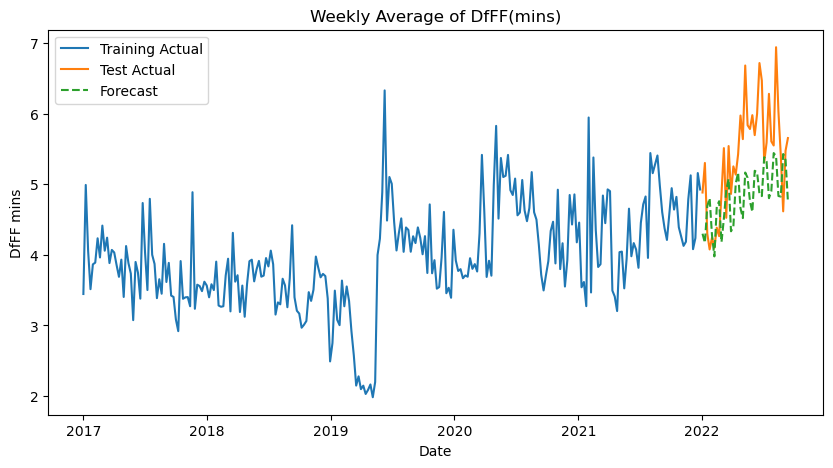

In [21]:
plt.figure(figsize=(10, 5))
plt.title('Weekly Average of DfFF(mins)')
plt.xlabel('Date')
plt.ylabel('DfFF mins') 
plt.plot(train['DfFF(mins)'], label='Training Actual')
plt.plot(test['DfFF(mins)'], label='Test Actual')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', linestyle='--')
plt.legend()
plt.show()

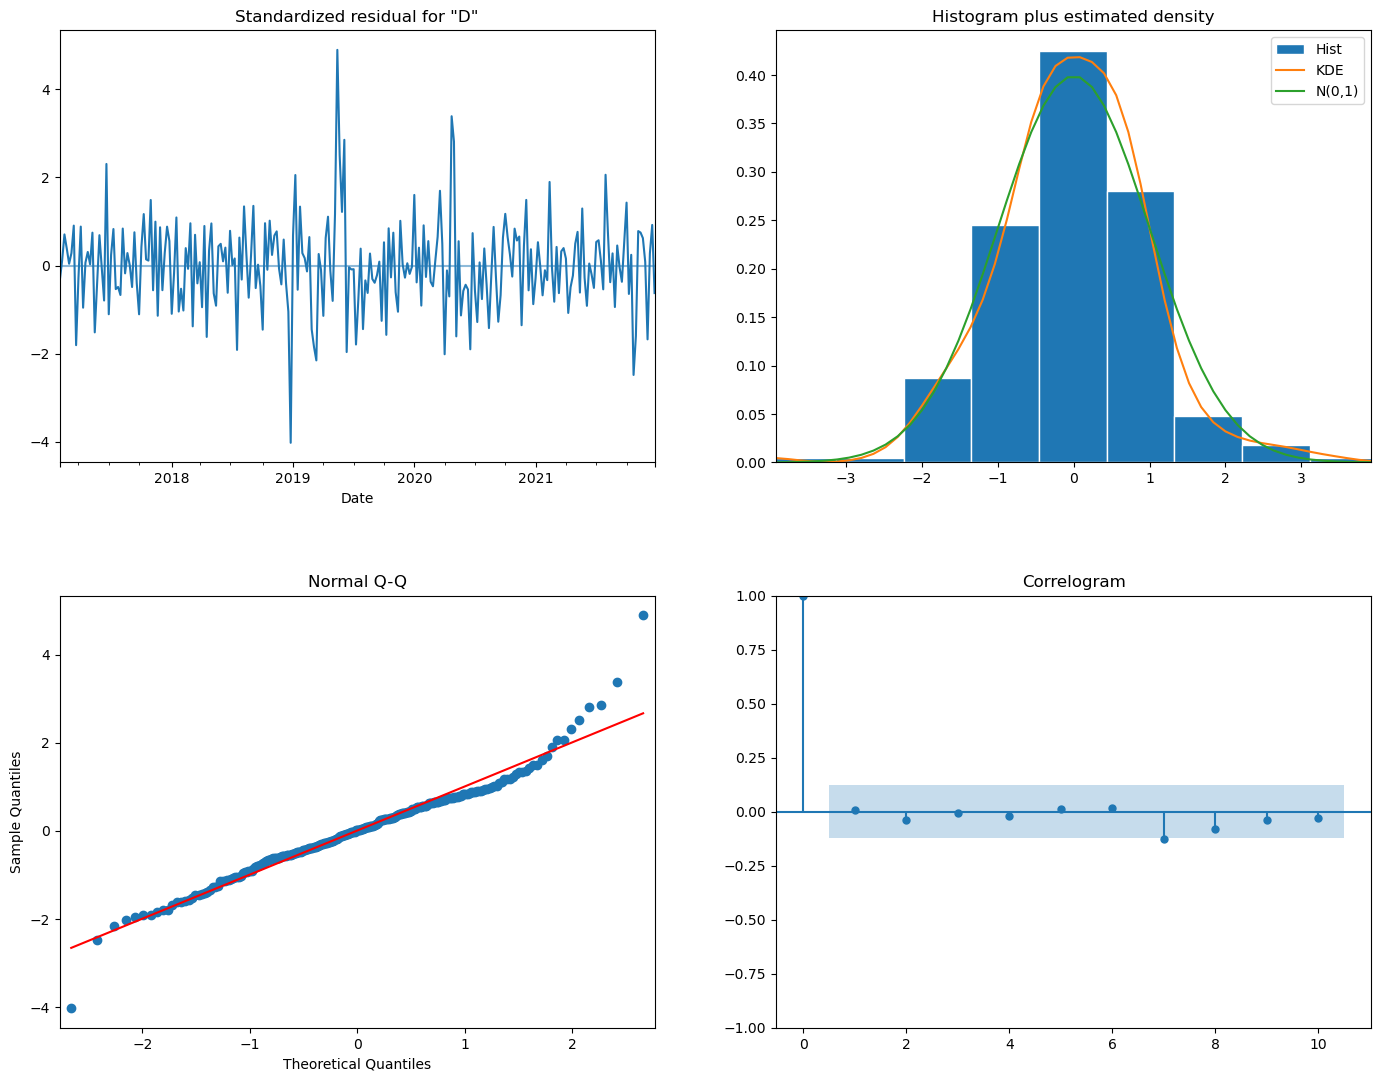

In [22]:
#model diagnostics
model_fit.plot_diagnostics(figsize=(15, 12)) 
plt.tight_layout(pad=5.0)
plt.show()


### SARIMAX Model Diagnostics Summary

- **Standardized Residuals**: The plot of the standardized residuals over time does not show any obvious patterns or trends, which indicates that the model residuals are random, a good sign of model fit. 

- **Histogram plus Estimated Density**: The histogram of the standardized residuals, overlaid with a Kernel Density Estimate (KDE) and a Normal (Gaussian) density plot, suggests that the residuals are approximately normally distributed. The KDE closely follows the N(0,1) line

- **Normal Q-Q**: The Normal Q-Q plot, which compares the quantiles of the model's residuals against a perfect normal distribution, shows points that mostly lie along the 45-degree line, indicating that the residuals are approximately normally distributed. There are some deviations in the upper quantiles, suggesting some potential heavy-tailedness.

- **Correlogram**: The correlogram (ACF plot) of the residuals shows that most autocorrelations are within the blue shaded area, which represents the 95% confidence interval for the hypothesis that there is no autocorrelation at that lag. This is a good sign that there is little to no autocorrelation in the residuals.

Overall, the diagnostics suggest that the model is reasonably well-fitted to the data


# CUSUM Analysis

In [34]:
df=pd.read_csv('df_clean2.csv')

In [35]:
df.head()

,Sev,StartLat,StartLng,Dist(mi),DfTyp(mins),DfFF(mins),CongSp,City,County,State,...,Vis(mi),WindDir,StartTime,EndTime,Precip(in),Year,Month,Day,TOD,Season
0,0,40.119274,-83.03465,1.8,0,1,Fast,Columbus,Franklin,OH,...,7.0,NW,12:42:00,13:16:05,0.00,2016,2,8,Afternoon,Winter
1,0,40.119274,-83.03465,1.8,0,1,Fast,Columbus,Franklin,OH,...,7.0,NW,12:42:00,13:16:05,0.02,2016,2,8,Afternoon,Winter
2,0,40.119274,-83.03465,1.8,0,1,Fast,Columbus,Franklin,OH,...,7.0,NW,12:42:00,13:16:05,0.02,2016,2,8,Afternoon,Winter
3,0,40.119274,-83.03465,1.8,0,1,Fast,Columbus,Franklin,OH,...,7.0,NW,12:42:00,13:16:05,0.03,2016,2,8,Afternoon,Winter
4,0,40.119274,-83.03465,1.8,0,1,Fast,Columbus,Franklin,OH,...,7.0,NW,12:42:00,13:16:05,0.00,2016,2,8,Afternoon,Winter


In [36]:
df['Year'].unique()

array([2016, 2017, 2018, 2019, 2020, 2021, 2022])

In [37]:
#after extensive analysis, I determined that the scale differnce was too large past 2019. For this reason, I minimized 
#the dataset to include 2019 and prior
df= df[(df['Year'] >= 2016) & (df['Year'] <= 2019)]

#also the two threshold lines need to be written in the right y axis scale, so I manually updated this in each visualization

### Potential Threshold Values Based on Variables

In [24]:
print(max(df['DfFF(mins)'])*.10)
print(max(df['DfTyp(mins)'])*.10)
print(max(df['Precip(in)'])*.10)
print(max(df['Hum(%)'])*.10)
print(max(df['Pres(in)'])*.10)
print(max(df['Vis(mi)'])*.10)

27.0
26.700000000000003
9.600000000000001
10.0
3.9890000000000003
2400.7000000000003


## DfFF versus Precipitation 

### Results: Increased precipitation leads to additional time compared to ideal, congestion-free conditions, cusum values for both spike at similar times througout the four year period

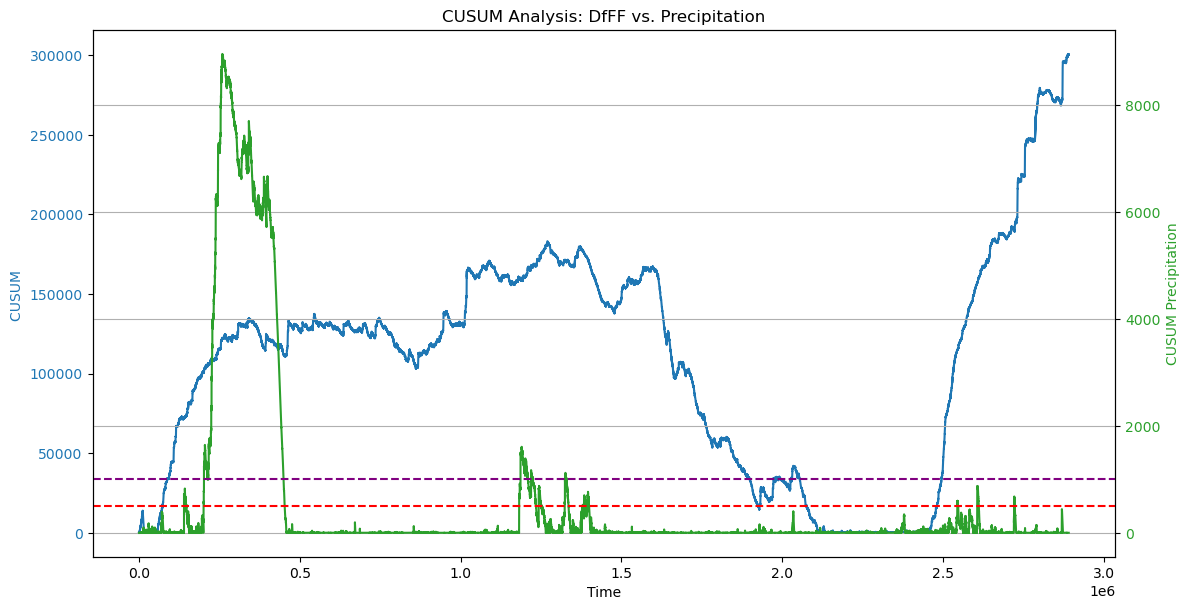

In [38]:
# Example reference value for distance traveled (mean distance)
reference_distance = df['DfFF(mins)'].mean()

# Calculate deviations from the reference value for distance traveled
deviations_distance = df['DfFF(mins)'] - reference_distance

# Example reference value for precipitation (mean precipitation)
reference_precipitation = df['Precip(in)'].mean()

# Calculate deviations from the reference value for precipitation
deviations_precipitation = df['Precip(in)'] - reference_precipitation

# Choose appropriate threshold and stabilizer values for CUSUM analysis
T = .1  # Example threshold
c = 0.1  # Example stabilizer

# Initialize CUSUM values for distance traveled and precipitation
cusum_distance = np.zeros(len(df))
cusum_precipitation = np.zeros(len(df))

# Calculate CUSUM values for distance traveled
for i in range(1, len(df)):
    cusum_distance[i] = max(0, cusum_distance[i-1] + deviations_distance[i] - c)

# Calculate CUSUM values for precipitation
for i in range(1, len(df)):
    cusum_precipitation[i] = max(0, cusum_precipitation[i-1] + deviations_precipitation[i] - c)
    
# Plot CUSUM charts for distance traveled and precipitation
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('CUSUM ', color=color)
ax1.plot(df.index, cusum_distance, label='DfFF', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('CUSUM Precipitation', color=color)  
ax2.plot(df.index, cusum_precipitation, label='CUSUM Precipitation', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axhline(y=500, color='red', linestyle='--', label=f'Threshold T={T}')
plt.axhline(y=1000, color='purple', linestyle='--', label=f'Threshold T2=1000')
fig.tight_layout()  
plt.title('CUSUM Analysis: DfFF vs. Precipitation')
plt.grid(True)
plt.show()

## DfFF versus Humidity

### Result: As humidity increases, additional time compared to ideal, congestion-free conditions decreases

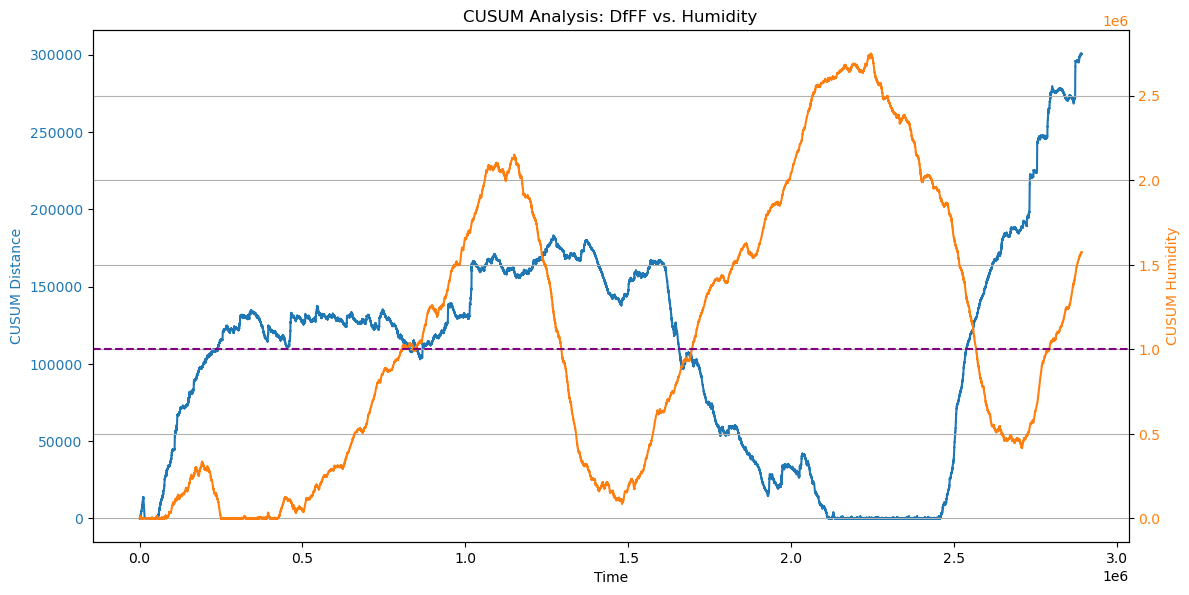

In [39]:
# Load your datasets (assuming they are already loaded into DataFrames named df_distance and df_humidity)
# Ensure both datasets have a common time index or timestamp column

# Example reference value for distance traveled (mean distance)
reference_distance = df['DfFF(mins)'].mean()

# Calculate deviations from the reference value for distance traveled
deviations_distance = df['DfFF(mins)'] - reference_distance

# Example reference value for humidity (mean humidity)
reference_humidity = df['Hum(%)'].mean()

# Calculate deviations from the reference value for humidity
deviations_humidity = df['Hum(%)'] - reference_humidity

# Choose appropriate threshold and stabilizer values for CUSUM analysis
T = 27  # Example threshold
c = 0.1  # Example stabilizer

# Initialize CUSUM values for distance traveled and humidity
cusum_distance = np.zeros(len(df))
cusum_humidity = np.zeros(len(df))

# Calculate CUSUM values for distance traveled
for i in range(1, len(df)):
    cusum_distance[i] = max(0, cusum_distance[i-1] + deviations_distance[i] - c)

# Calculate CUSUM values for humidity
for i in range(1, len(df)):
    cusum_humidity[i] = max(0, cusum_humidity[i-1] + deviations_humidity[i] - c)

# Plot CUSUM charts for distance traveled and humidity
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('CUSUM Distance', color=color)
ax1.plot(df.index, cusum_distance, label='CUSUM DfFF', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('CUSUM Humidity', color=color)  
ax2.plot(df.index, cusum_humidity, label='CUSUM Humidity', color=color)
ax2.tick_params(axis='y', labelcolor=color)



plt.axhline(y=1000000, color='purple', linestyle='--', label=f'Threshold T2=1000')
fig.tight_layout()  
plt.title('CUSUM Analysis: DfFF vs. Humidity')
plt.grid(True)
plt.show()


## DfFF(mins) versus Pres(in)

### Result: appears to be uncorrelated

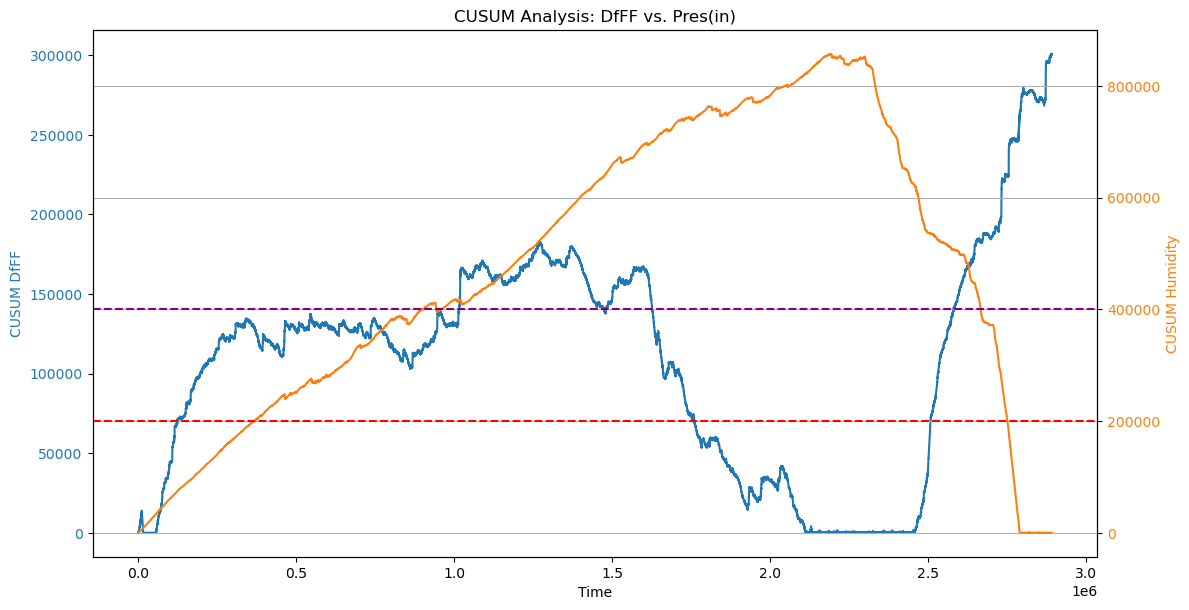

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your datasets (assuming they are already loaded into DataFrames named df_distance and df_humidity)
# Ensure both datasets have a common time index or timestamp column

# Example reference value for distance traveled (mean distance)
reference_distance = df['DfFF(mins)'].mean()

# Calculate deviations from the reference value for distance traveled
deviations_distance = df['DfFF(mins)'] - reference_distance

# Example reference value for humidity (mean humidity)
reference_humidity = df['Pres(in)'].mean()

# Calculate deviations from the reference value for humidity
deviations_humidity = df['Pres(in)'] - reference_humidity

# Choose appropriate threshold and stabilizer values for CUSUM analysis
T = 1  # Example threshold
c = 0.1  # Example stabilizer

# Initialize CUSUM values for distance traveled and humidity
cusum_distance = np.zeros(len(df))
cusum_humidity = np.zeros(len(df))

# Calculate CUSUM values for distance traveled
for i in range(1, len(df)):
    cusum_distance[i] = max(0, cusum_distance[i-1] + deviations_distance[i] - c)

# Calculate CUSUM values for humidity
for i in range(1, len(df)):
    cusum_humidity[i] = max(0, cusum_humidity[i-1] + deviations_humidity[i] - c)

# Plot CUSUM charts for distance traveled and humidity
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('CUSUM DfFF', color=color)
ax1.plot(df.index, cusum_distance, label='CUSUM DfFF', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('CUSUM Humidity', color=color)  
ax2.plot(df.index, cusum_humidity, label='CUSUM Humidity', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axhline(y=200000, color='red', linestyle='--', label=f'Threshold T2=1.5')
plt.axhline(y=400000, color='purple', linestyle='--', label=f'Threshold T2=1.5')
fig.tight_layout()  
plt.title('CUSUM Analysis: DfFF vs. Pres(in)')
plt.grid(True)
plt.show()


## DfFF(min) versus Visability 

### Results: As visibility increases so does additional traffic time

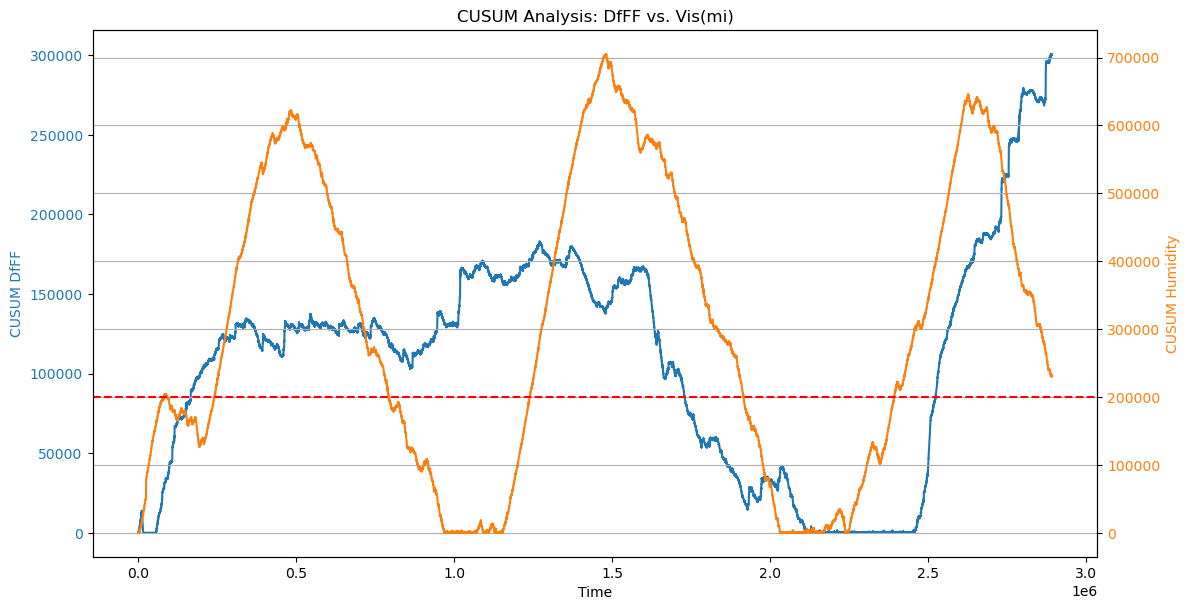

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your datasets (assuming they are already loaded into DataFrames named df_distance and df_humidity)
# Ensure both datasets have a common time index or timestamp column

# Example reference value for distance traveled (mean distance)
reference_distance = df['DfFF(mins)'].mean()

# Calculate deviations from the reference value for distance traveled
deviations_distance = df['DfFF(mins)'] - reference_distance

# Example reference value for humidity (mean humidity)
reference_humidity = df['Vis(mi)'].mean()

# Calculate deviations from the reference value for humidity
deviations_humidity = df['Vis(mi)'] - reference_humidity

# Choose appropriate threshold and stabilizer values for CUSUM analysis
T = 1  # Example threshold
c = 0.1  # Example stabilizer

# Initialize CUSUM values for distance traveled and humidity
cusum_distance = np.zeros(len(df))
cusum_humidity = np.zeros(len(df))

# Calculate CUSUM values for distance traveled
for i in range(1, len(df)):
    cusum_distance[i] = max(0, cusum_distance[i-1] + deviations_distance[i] - c)

# Calculate CUSUM values for humidity
for i in range(1, len(df)):
    cusum_humidity[i] = max(0, cusum_humidity[i-1] + deviations_humidity[i] - c)

# Plot CUSUM charts for distance traveled and humidity
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('CUSUM DfFF', color=color)
ax1.plot(df.index, cusum_distance, label='CUSUM DfFF', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('CUSUM Humidity', color=color)  
ax2.plot(df.index, cusum_humidity, label='CUSUM Humidity', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axhline(y=200000, color='red', linestyle='--', label=f'Threshold T={T}')
fig.tight_layout()  
plt.title('CUSUM Analysis: DfFF vs. Vis(mi)')
plt.grid(True)
plt.show()


## DfType versus Precipitation 

### Results: Increased precipitation leads to increases traffic

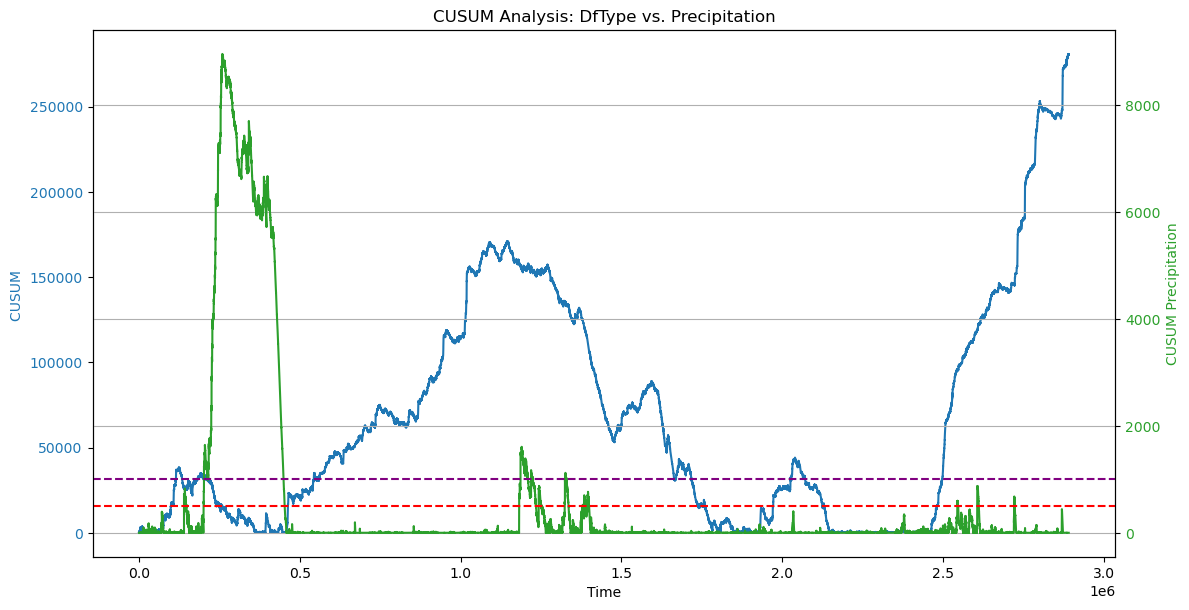

In [42]:
# Example reference value for distance traveled (mean distance)
reference_distance = df['DfTyp(mins)'].mean()

# Calculate deviations from the reference value for distance traveled
deviations_distance = df['DfTyp(mins)'] - reference_distance

# Example reference value for precipitation (mean precipitation)
reference_precipitation = df['Precip(in)'].mean()

# Calculate deviations from the reference value for precipitation
deviations_precipitation = df['Precip(in)'] - reference_precipitation

# Choose appropriate threshold and stabilizer values for CUSUM analysis
T = 27  # Example threshold
c = 0.1  # Example stabilizer

# Initialize CUSUM values for distance traveled and precipitation
cusum_distance = np.zeros(len(df))
cusum_precipitation = np.zeros(len(df))

# Calculate CUSUM values for distance traveled
for i in range(1, len(df)):
    cusum_distance[i] = max(0, cusum_distance[i-1] + deviations_distance[i] - c)

# Calculate CUSUM values for precipitation
for i in range(1, len(df)):
    cusum_precipitation[i] = max(0, cusum_precipitation[i-1] + deviations_precipitation[i] - c)

# Plot CUSUM charts for distance traveled and precipitation
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('CUSUM ', color=color)
ax1.plot(df.index, cusum_distance, label='CUSUM DfType', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:green'
ax2.set_ylabel('CUSUM Precipitation', color=color)  
ax2.plot(df.index, cusum_precipitation, label='CUSUM Precipitation', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axhline(y=500, color='red', linestyle='--', label=f'Threshold T={T}')

plt.axhline(y=1000, color='purple', linestyle='--', label=f'Threshold T2=1000')
fig.tight_layout()  
plt.title('CUSUM Analysis: DfType vs. Precipitation')
plt.grid(True)
plt.show()

## DfType versus Pres(in)

### Results: There seems to be no correlation

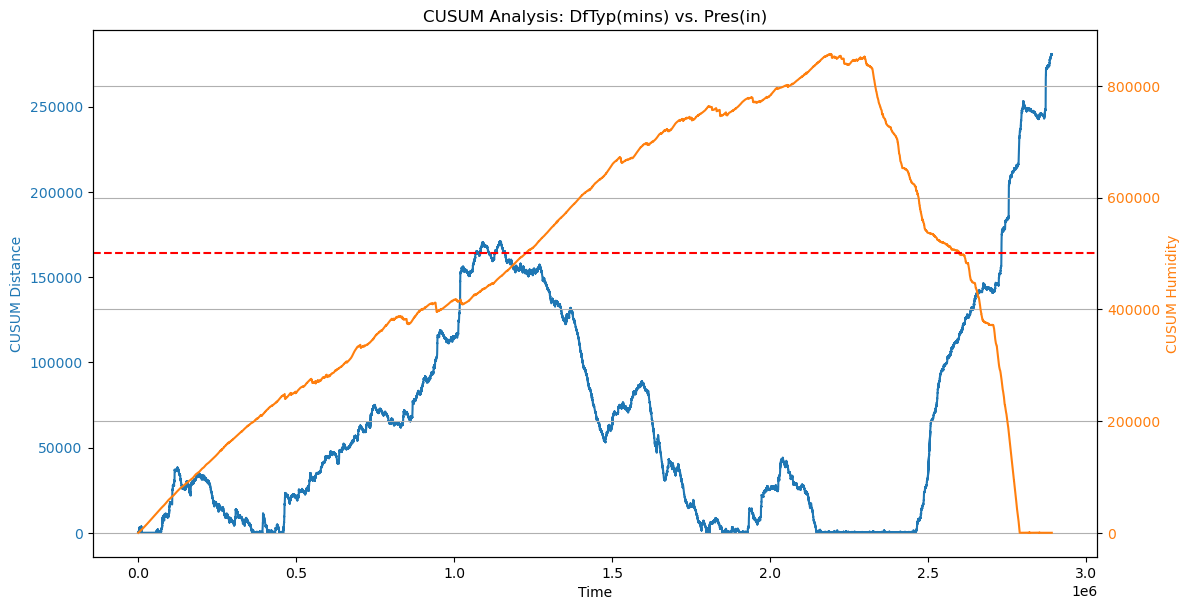

In [45]:
# Example reference value for distance traveled (mean distance)
reference_distance = df['DfTyp(mins)'].mean()

# Calculate deviations from the reference value for distance traveled
deviations_distance = df['DfTyp(mins)'] - reference_distance

# Example reference value for humidity (mean humidity)
reference_humidity = df['Pres(in)'].mean()

# Calculate deviations from the reference value for humidity
deviations_humidity = df['Pres(in)'] - reference_humidity

# Choose appropriate threshold and stabilizer values for CUSUM analysis
T = 1  # Example threshold
c = 0.1  # Example stabilizer

# Initialize CUSUM values for distance traveled and humidity
cusum_distance = np.zeros(len(df))
cusum_humidity = np.zeros(len(df))

# Calculate CUSUM values for distance traveled
for i in range(1, len(df)):
    cusum_distance[i] = max(0, cusum_distance[i-1] + deviations_distance[i] - c)

# Calculate CUSUM values for humidity
for i in range(1, len(df)):
    cusum_humidity[i] = max(0, cusum_humidity[i-1] + deviations_humidity[i] - c)

# Plot CUSUM charts for distance traveled and humidity
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('CUSUM Distance', color=color)
ax1.plot(df.index, cusum_distance, label='DfTyp(mins)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('CUSUM Humidity', color=color)  
ax2.plot(df.index, cusum_humidity, label='CUSUM Humidity', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axhline(y=500000, color='red', linestyle='--', label=f'Threshold T={T}')
fig.tight_layout()  
plt.title('CUSUM Analysis: DfTyp(mins) vs. Pres(in)')
plt.grid(True)
plt.show()


## DfType versus Humidity 
### Results: as humidity increases so does additional time compared to ideal, congestion-free conditions

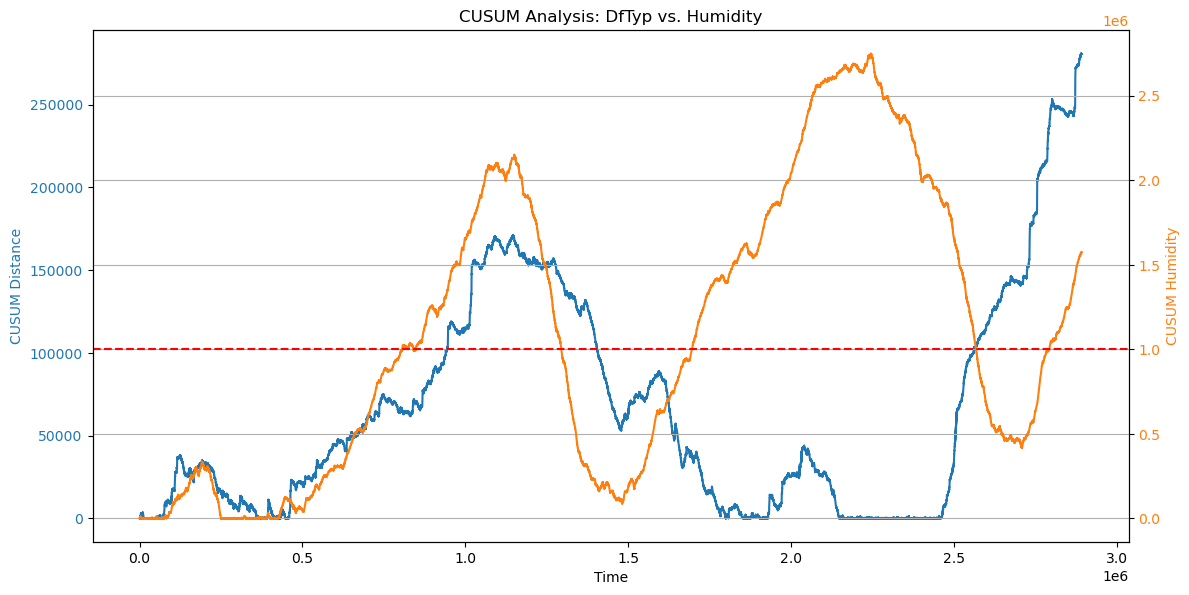

In [46]:
# Load your datasets (assuming they are already loaded into DataFrames named df_distance and df_humidity)
# Ensure both datasets have a common time index or timestamp column

# Example reference value for distance traveled (mean distance)
reference_distance = df['DfTyp(mins)'].mean()

# Calculate deviations from the reference value for distance traveled
deviations_distance = df['DfTyp(mins)'] - reference_distance

# Example reference value for humidity (mean humidity)
reference_humidity = df['Hum(%)'].mean()

# Calculate deviations from the reference value for humidity
deviations_humidity = df['Hum(%)'] - reference_humidity

# Choose appropriate threshold and stabilizer values for CUSUM analysis
T = 27  # Example threshold
c = 0.1  # Example stabilizer

# Initialize CUSUM values for distance traveled and humidity
cusum_distance = np.zeros(len(df))
cusum_humidity = np.zeros(len(df))

# Calculate CUSUM values for distance traveled
for i in range(1, len(df)):
    cusum_distance[i] = max(0, cusum_distance[i-1] + deviations_distance[i] - c)

# Calculate CUSUM values for humidity
for i in range(1, len(df)):
    cusum_humidity[i] = max(0, cusum_humidity[i-1] + deviations_humidity[i] - c)

# Plot CUSUM charts for distance traveled and humidity
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('CUSUM Distance', color=color)
ax1.plot(df.index, cusum_distance, label='CUSUM DfTyp', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('CUSUM Humidity', color=color)  
ax2.plot(df.index, cusum_humidity, label='CUSUM Humidity', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axhline(y=1000000, color='red', linestyle='--', label=f'Threshold T={T}')
fig.tight_layout()  
plt.title('CUSUM Analysis: DfTyp vs. Humidity')
plt.grid(True)
plt.show()


## DfType versus Visibility  
### Results: As Visibility lowers, additional time compared to ideal, congestion-free conditions increases

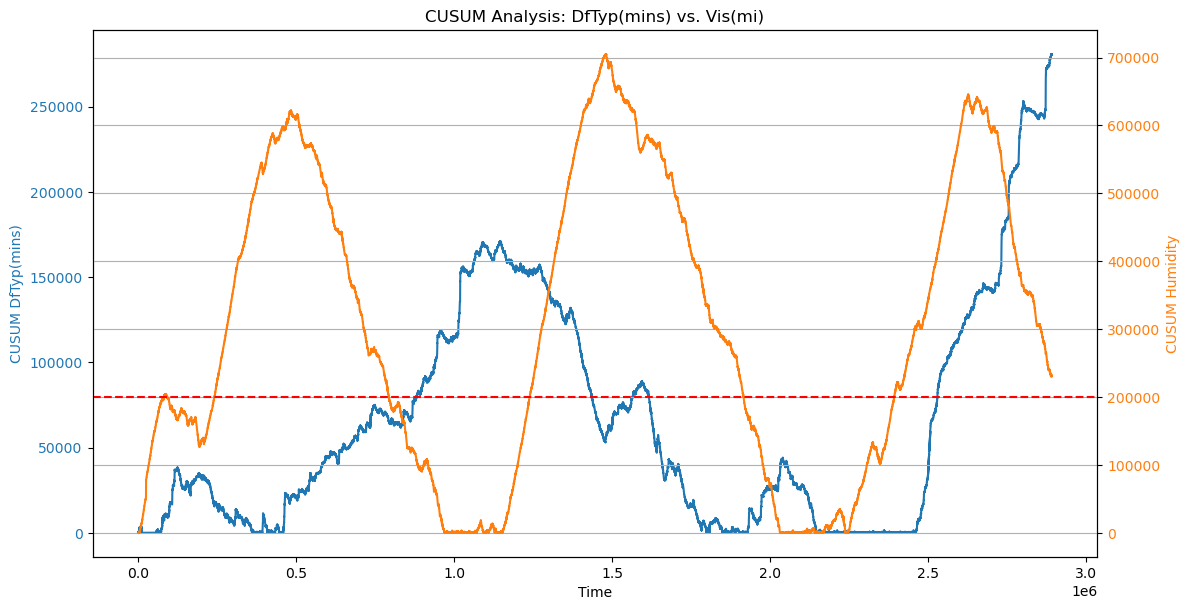

In [47]:
# Example reference value for distance traveled (mean distance)
reference_distance = df['DfTyp(mins)'].mean()

# Calculate deviations from the reference value for distance traveled
deviations_distance = df['DfTyp(mins)'] - reference_distance

# Example reference value for humidity (mean humidity)
reference_humidity = df['Vis(mi)'].mean()

# Calculate deviations from the reference value for humidity
deviations_humidity = df['Vis(mi)'] - reference_humidity

# Choose appropriate threshold and stabilizer values for CUSUM analysis
T = 1  # Example threshold
c = 0.1  # Example stabilizer

# Initialize CUSUM values for distance traveled and humidity
cusum_distance = np.zeros(len(df))
cusum_humidity = np.zeros(len(df))

# Calculate CUSUM values for distance traveled
for i in range(1, len(df)):
    cusum_distance[i] = max(0, cusum_distance[i-1] + deviations_distance[i] - c)

# Calculate CUSUM values for humidity
for i in range(1, len(df)):
    cusum_humidity[i] = max(0, cusum_humidity[i-1] + deviations_humidity[i] - c)

# Plot CUSUM charts for distance traveled and humidity
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('CUSUM DfTyp(mins)', color=color)
ax1.plot(df.index, cusum_distance, label='CUSUM DfTyp(mins)', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('CUSUM Humidity', color=color)  
ax2.plot(df.index, cusum_humidity, label='CUSUM Humidity', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.axhline(y=200000, color='red', linestyle='--', label=f'Threshold T={T}')
fig.tight_layout()  
plt.title('CUSUM Analysis: DfTyp(mins) vs. Vis(mi)')
plt.grid(True)
plt.show()
